# Visualize Results
Improved PPO results based on the spinup implementation.

In [1]:
import pandas as pd
import json

import os
import numpy as np
import pickle as pkl
from gym import spaces
from scipy.optimize import minimize
from tqdm import tnrange

import sys 
sys.path.insert(0, './rl-multilayer/')
from RLMultilayer.utils import visualize_progress, summarize_res, combine_tracker, load_exp_res, DesignTracker

import glob
from torch import nn
import torch
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from RLMultilayer.taskenvs import tasks
from RLMultilayer.utils import cal_reward
from RLMultilayer.utils import TMM_sim

# matplotlib.rcParams.update({'font.size': 60})

import seaborn as sns
sns.set(font_scale=1)
import re 

%matplotlib inline

In [2]:
import tqdm

In [3]:
def finetune(simulator, m0, x0, target, display=False, bounds=None):
    '''
    Finetune the structure using quasi-Newton's method.
    
    Args:
        m0: materials list given by the upstream RL
        x0: thicknesses given by the upstream RL
        display: if true, then plot the spectrum before and after the finetuning.
        
    Returns:
        x_opt: finetuned thickness list
    '''
    
    def objective_func(x):
        R, T, A = simulator.spectrum(m0, [np.inf]+list(x)+[np.inf])
        return 1-cal_reward(R, T, A, target)
    
    if bounds is None:
        bounds = [(15, 200)] * len(x0)
    
    res = minimize(objective_func, x0, bounds=bounds, options={'disp':True})
    x_opt = [int(item) for item in res.x]
    
    if display:
        plt.figure()
        simulator.spectrum(m0, [np.inf]+x0+[np.inf], title=True, plot=True)
        plt.figure()
        simulator.spectrum(m0, [np.inf]+x_opt+[np.inf], title=True, plot=True)
    
    return x_opt, res

In [4]:
def plot_results(folder, col=None, hue=None):
    
    df = load_exp_res(folder)
    sns.set(font_scale=1)
    
    reward_factor = df['reward_factor']
    df['LowEpRet'] = (df['AverageEpRet'] - 0.5 * df['StdEpRet']) / reward_factor
    df['HighEpRet'] = (df['AverageEpRet'] + 0.5 * df['StdEpRet']) / reward_factor
    df['NormalizedAverageEpRet'] = df['AverageEpRet']  / reward_factor
    g = sns.FacetGrid(df, col=col, hue=hue, sharey=False)
    g = g.map(plt.plot, "NormalizedAverageEpRet").add_legend()
    g = g.map(plt.fill_between, "Epoch", "LowEpRet", "HighEpRet" , **{'alpha':0.5}).add_legend()
    g.set_ylabels('AverageEpRet')

    df['NormalizedMaxEpRet'] = df['MaxEpRet'] / reward_factor
    g = sns.FacetGrid(df, col=col, hue=hue, sharey=False)
    g = g.map(plt.plot, "Epoch", 'NormalizedMaxEpRet').add_legend()

    plt.figure()
    sns.lineplot(y='AverageVVals', x='Epoch', data=df, ci='sd')

    plt.figure()
    sns.lineplot(y='Entropy', x='Epoch', data=df, ci='sd')

    print(df.iloc[df['MaxEpRet'].to_numpy().argmax()]['best_design'])

    return df

In [5]:
def visualize_results(folder, x=None):
    
    if x is None:
        x = 'Epoch'
    
    df = load_exp_res(folder)
    df['seed'] = ['$%s$' %item for item in df['seed']]
    
    fig, ax = plt.subplots(2,2, figsize=(10, 10))
    ax = ax.ravel()
    sns.lineplot(x=x, y='MaxEpRet', data=df, hue='seed', ci='sd', legend=None, ax=ax[0])
    sns.lineplot(x=x, y='AverageEpRet', data=df, hue='seed', ci='sd', legend=None, ax=ax[1])
    sns.lineplot(x=x, y='Entropy', data=df, hue='seed', ci='sd',  ax=ax[2])
    sns.lineplot(x=x, y='EpLen', data=df, hue='seed', ci='sd',  ax=ax[3])

    best_designs = []
    for s in df['seed'].unique():
        best_designs.append(df[df['seed']==s]['best_design'].iloc[0])
        
    return best_designs

In [6]:
def extract_designs(best_designs):
    m0s = []
    x0s = []
    merits = []
    for i in range(len(best_designs)):
        design = best_designs[i][0].split(',')[0].split('|')
        m0 = [item.split(' ')[0] for item in design]
        x0 = [item.split(' ')[1] for item in design]
        merit = best_designs[i][0].split(',')[1].split(' ')[2]
        x0 = [int(item) for item in x0]

        m0s.append(m0)
        x0s.append(x0)
        merits.append(float(merit))
    
        
        
    return m0s, x0s, merits

## compare performance
1. max ep ret
2. average ep ret

In [4]:
5 folder = '/home/hzwang/Experiments/0301_scalar_thick'
df_scalarthick = load_exp_res(folder)

In [5]:
b# baseline
folder = '/home/hzwang/Experiments/0229_spectrum_off'
df_baseline = load_exp_res(folder)

# with 1d-cnn spectrum
folder = '/home/hzwang/Experiments/0229_spectrum_on'
df_spectrum = load_exp_res(folder)

# hierarchical 
folder = '/home/hzwang/Experiments/0229_hierarchical'
df_hierarchical = load_exp_res(folder)

# reward scaling
folder = '/home/hzwang/Experiments/0229_scaling'
df_scaling = load_exp_res(folder)

# ppo_a2c
folder = '/home/hzwang/Experiments/0229_ppo_a2c'
df_ppo = load_exp_res(folder)

In [6]:
print(df_baseline.iloc[df_baseline['MaxEpRet'].to_numpy().argmax()][['spectrum_repr', 'best_design', 'MaxEpRet']])
print(df_spectrum.iloc[df_spectrum['MaxEpRet'].to_numpy().argmax()][['spectrum_repr', 'best_design', 'MaxEpRet']])
print(df_hierarchical.iloc[df_hierarchical['MaxEpRet'].to_numpy().argmax()][['spectrum_repr', 'best_design', 'MaxEpRet']])
print(df_scaling.iloc[df_scaling['MaxEpRet'].to_numpy().argmax()][['spectrum_repr', 'best_design', 'MaxEpRet']])
print(df_ppo.iloc[df_ppo['MaxEpRet'].to_numpy().argmax()][['spectrum_repr', 'best_design', 'MaxEpRet']])

spectrum_repr                                                False
best_design      [MgF2 100 nm|TiO2 65 nm|Ge 35 nm|Cr 145 nm|Cr ...
MaxEpRet                                                  0.911981
Name: 33, dtype: object
spectrum_repr                                                 True
best_design      [TiO2 70 nm|Si 40 nm|Ge 30 nm|Cr 170 nm|Cr 150...
MaxEpRet                                                  0.910158
Name: 117, dtype: object
spectrum_repr                                                False
best_design      [MgF2 95 nm|TiO2 65 nm|Ge 40 nm|Cr 145 nm|Cr 1...
MaxEpRet                                                  0.911766
Name: 32, dtype: object
spectrum_repr                                                False
best_design      [MgF2 100 nm|TiO2 65 nm|Ge 35 nm|Cr 145 nm|Cr ...
MaxEpRet                                                   91.1981
Name: 33, dtype: object
spectrum_repr                                                False
best_design      [MgF2 100 nm|Ti

In [ ]:
# effect of adding spectrum
df = pd.concat((df_baseline, df_spectrum))
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.lineplot(x='Epoch', y='MaxEpRet', data=df, hue='spectrum_repr', ci='sd', ax=ax[0])
sns.lineplot(x='Epoch', y='AverageEpRet', data=df, hue='spectrum_repr', ci='sd', ax=ax[1])


In [ ]:
# effect of adding hierarchcial actions
df = pd.concat((df_baseline, df_hierarchical))
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.lineplot(x='Epoch', y='MaxEpRet', data=df, hue='ac_kwargs_hierarchical', ci='sd', ax=ax[0])
sns.lineplot(x='Epoch', y='AverageEpRet', data=df, hue='ac_kwargs_hierarchical', ci='sd', ax=ax[1])
print(df.iloc[df['MaxEpRet'].to_numpy().argmax()][['ac_kwargs_hierarchical', 'best_design', 'MaxEpRet']])

In [ ]:
# effect of adding reward scaling
df = pd.concat((df_baseline, df_scaling))

df['NormalizedAverageEpRet'] = df['AverageEpRet'] / df['reward_factor']
df['NormalizedMaxEpRet'] = df['MaxEpRet'] / df['reward_factor']
df['reward_factor'] = ['$%s$' %item for item in df['reward_factor']]

fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.lineplot(x='Epoch', y='NormalizedMaxEpRet', data=df, hue='reward_factor', ci='sd', ax=ax[0])
sns.lineplot(x='Epoch', y='NormalizedAverageEpRet', data=df, hue='reward_factor', ci='sd', ax=ax[1])
df.iloc[df['NormalizedMaxEpRet'].to_numpy().argmax()][['reward_factor', 'best_design']]
df.iloc[df['NormalizedAverageEpRet'].to_numpy().argmax()][['reward_factor', 'NormalizedAverageEpRet', 'best_design']]

In [10]:
df.columns

Index(['Epoch', 'AverageEpRet', 'StdEpRet', 'MaxEpRet', 'MinEpRet', 'EpLen',
       'AverageAct', 'StdAct', 'MaxAct', 'MinAct', 'AverageRetBuf',
       'StdRetBuf', 'MaxRetBuf', 'MinRetBuf', 'AverageVVals', 'StdVVals',
       'MaxVVals', 'MinVVals', 'TotalEnvInteracts', 'LossPi', 'LossV',
       'DeltaLossPi', 'DeltaLossV', 'Entropy', 'KL', 'ClipFrac', 'StopIter',
       'Time', 'FPS', 'ac_kwargs_cell_size', 'ac_kwargs_channels',
       'ac_kwargs_hidden_sizes', 'ac_kwargs_hierarchical',
       'ac_kwargs_not_repeat', 'ac_kwargs_ortho_init', 'actor_critic', 'beta',
       'clip_ratio', 'env_fn', 'epochs', 'exp_name', 'gamma', 'lam',
       'max_ep_len', 'pi_lr', 'reward_factor', 'save_freq', 'seed',
       'spectrum_repr', 'steps_per_epoch', 'target_kl', 'train_pi_iters',
       'train_v_iters', 'use_rnn', 'vf_lr', 'best_design',
       'NormalizedAverageEpRet', 'NormalizedMaxEpRet'],
      dtype='object')

In [ ]:
# effect of iteration
folder = '/home/hzwang/Experiments/0229_ppo_a2c'
df_ppo = load_exp_res(folder)
# df = pd.concat((df_baseline, df_ppo))
df_ppo['train_pi_iters'] = ['$%s$' %item for item in df_ppo['train_pi_iters']]
df_ppo['seed'] = ['$%s$' %item for item in df_ppo['seed']]
# fig, ax = plt.subplots(1,2, figsize=(15,5))
# sns.lineplot(x='Epoch', y='MaxEpRet', data=df, hue='train_pi_iters', ci='sd', ax=ax[0])
# sns.lineplot(x='Epoch', y='AverageEpRet', data=df, hue='train_pi_iters', ci='sd', ax=ax[1])

sns.relplot(x='Epoch', y='MaxEpRet', data=df_ppo, hue='seed', ci='sd', col='train_pi_iters', kind='line')
# print(df.iloc[df['AverageEpRet'].to_numpy().argmax()][['train_pi_iters', 'best_design', 'MaxEpRet']])



In [ ]:
folder = '/home/hzwang/Experiments/0301_ppo_bottom_up'
df_ppo = load_exp_res(folder)
# df_ppo = df_ppo[df_ppo['seed'] != 42]
df_ppo['seed'] = ['$%s$' %item for item in df_ppo['seed']]
sns.relplot(x='Epoch', y='MaxEpRet', data=df_ppo, hue='seed', ci='sd', col='train_pi_iters', kind='line')
sns.relplot(x='Epoch', y='AverageEpRet', data=df_ppo, hue='seed', ci='sd', col='train_pi_iters', kind='line')
sns.relplot(x='Epoch', y='Entropy', data=df_ppo, hue='seed', ci='sd', col='train_pi_iters', kind='line')
df_ppo.iloc[df_ppo['MaxEpRet'].to_numpy().argmax()]['best_design']

In [ ]:
folder = '/home/hzwang/Experiments/0301_ppo_lam'
df_ppo = load_exp_res(folder)
# df_ppo = df_ppo[df_ppo['seed'] != 42]
df_ppo['seed'] = ['$%s$' %item for item in df_ppo['seed']]
sns.relplot(x='Epoch', y='MaxEpRet', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')
sns.relplot(x='Epoch', y='AverageEpRet', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')
sns.relplot(x='Epoch', y='Entropy', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')
df_ppo.iloc[df_ppo['MaxEpRet'].to_numpy().argmax()]['best_design']

In [ ]:
folder = '/home/hzwang/Experiments/0302_ppo_lowlr'
df_ppo = load_exp_res(folder)
# df_ppo = df_ppo[df_ppo['seed'] != 42]
df_ppo['seed'] = ['$%s$' %item for item in df_ppo['seed']]
sns.relplot(x='Epoch', y='MaxEpRet', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')
sns.relplot(x='Epoch', y='AverageEpRet', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')
sns.relplot(x='Epoch', y='Entropy', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')
df_ppo.iloc[df_ppo['MaxEpRet'].to_numpy().argmax()]['best_design']

In [11]:
folder = '/home/hzwang/Experiments/0302_ppo_sparse'
df_ppo = load_exp_res(folder)

['TiO2 25 nm|MgF2 35 nm|TiO2 65 nm|Si 35 nm|Ge 25 nm|Cr 25 nm|Ge 25 nm|Cr 195 nm|Ge 195 nm, Merit 0.967']

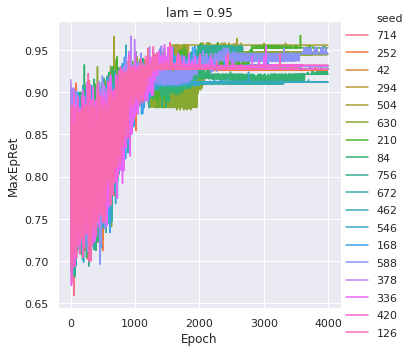

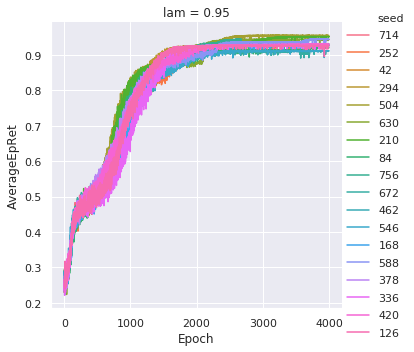

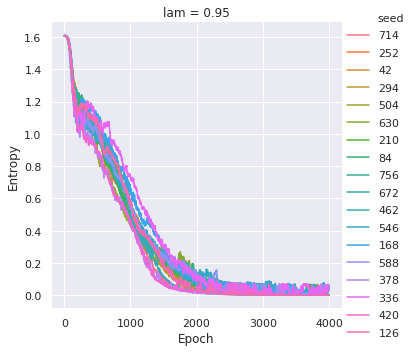

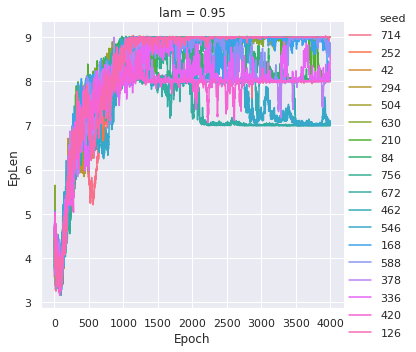

In [15]:
folder = '/home/hzwang/Experiments/0302_ppo_sparse'
df_ppo = load_exp_res(folder)
# df_ppo = df_ppo[df_ppo['seed'] != 42]
df_ppo['seed'] = ['$%s$' %item for item in df_ppo['seed']]
sns.relplot(x='Epoch', y='MaxEpRet', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')
sns.relplot(x='Epoch', y='AverageEpRet', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')
sns.relplot(x='Epoch', y='Entropy', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')

sns.relplot(x='Epoch', y='EpLen', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')

df_ppo.iloc[df_ppo['MaxEpRet'].to_numpy().argmax()]['best_design']

In [16]:
df_ppo[df_ppo['seed'] == '$42$']['best_design'].iloc[-1], df_ppo[df_ppo['seed'] == '$84$']['best_design'].iloc[-1], df_ppo[df_ppo['seed'] == '$126$']['best_design'].iloc[-1]

(['TiO2 30 nm|MgF2 30 nm|TiO2 50 nm|Si 30 nm|Ge 30 nm|Cr 20 nm|Ge 30 nm|Cr 185 nm|Ge 85 nm, Merit 0.956'],
 ['TiO2 35 nm|MgF2 35 nm|Si 20 nm|TiO2 20 nm|Ge 35 nm|Cr 20 nm|Ge 20 nm|Cr 190 nm|Ge 185 nm, Merit 0.939'],
 ['TiO2 25 nm|MgF2 25 nm|TiO2 70 nm|Si 25 nm|Ge 25 nm|Cr 25 nm|Ge 25 nm|Cr 175 nm|Ge 120 nm, Merit 0.959'])

['MgF2 135 nm|TiO2 45 nm|Si 35 nm|Ge 35 nm|Cr 25 nm|Ge 35 nm|Cr 35 nm|Ge 40 nm|Cr 125 nm, Merit 0.979']

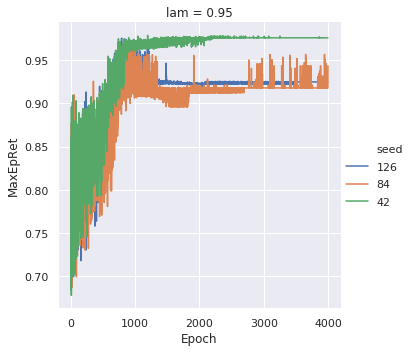

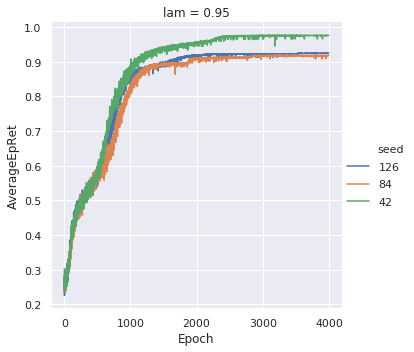

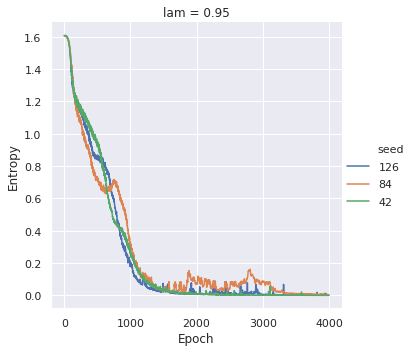

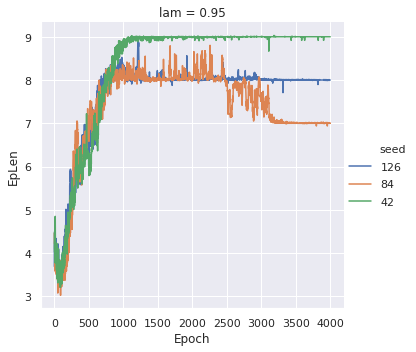

In [17]:
folder = '/home/hzwang/Experiments/0303_test'
df_ppo = load_exp_res(folder)
# df_ppo = df_ppo[df_ppo['seed'] != 42]
df_ppo['seed'] = ['$%s$' %item for item in df_ppo['seed']]
sns.relplot(x='Epoch', y='MaxEpRet', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')
sns.relplot(x='Epoch', y='AverageEpRet', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')
sns.relplot(x='Epoch', y='Entropy', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')

sns.relplot(x='Epoch', y='EpLen', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')

df_ppo.iloc[df_ppo['MaxEpRet'].to_numpy().argmax()]['best_design']

['MgF2 125 nm|TiO2 50 nm|Si 40 nm|Ge 25 nm|Cr 25 nm|Si 40 nm|Cr 25 nm|TiO2 40 nm|Cr 155 nm, Merit 0.986']

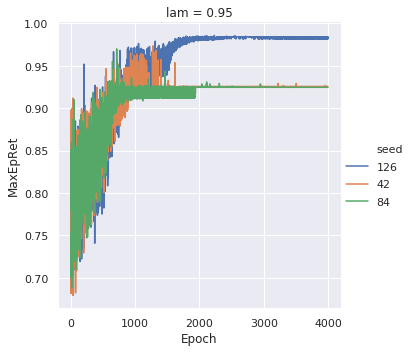

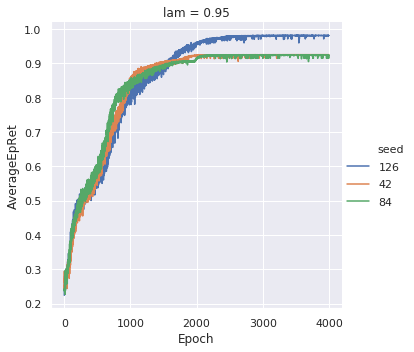

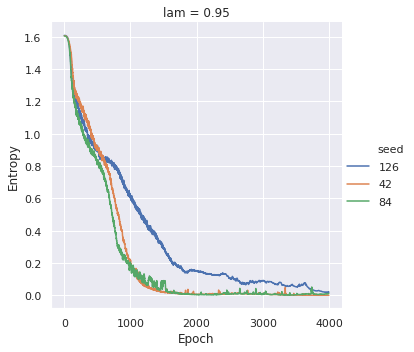

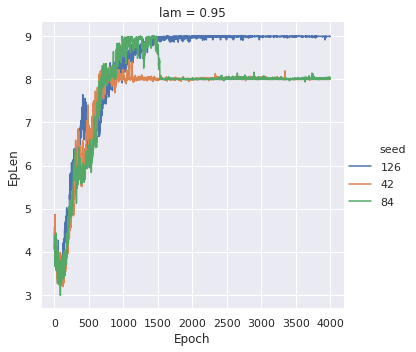

In [18]:
folder = '/home/hzwang/Experiments/0303_hierarchical'
df_ppo = load_exp_res(folder)
# df_ppo = df_ppo[df_ppo['seed'] != 42]
df_ppo['seed'] = ['$%s$' %item for item in df_ppo['seed']]
sns.relplot(x='Epoch', y='MaxEpRet', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')
sns.relplot(x='Epoch', y='AverageEpRet', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')
sns.relplot(x='Epoch', y='Entropy', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')

sns.relplot(x='Epoch', y='EpLen', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')

df_ppo.iloc[df_ppo['MaxEpRet'].to_numpy().argmax()]['best_design']

In [31]:
# compare hierarchical action
folder = '/home/hzwang/Experiments/0303_test'
df_nonh= load_exp_res(folder)

folder = '/home/hzwang/Experiments/0303_hierarchical'
df_h = load_exp_res(folder)

df = pd.concat((df_nonh, df_h))
df['seed'] = ['$%s$'%s for s in df['seed']]

KeyboardInterrupt: 

In [ ]:
sns.relplot(x='Epoch', y='MaxEpRet', data=df, hue='ac_kwargs_hierarchical', col='seed', ci='sd', kind='line')
sns.relplot(x='Epoch', y='AverageEpRet', data=df, hue='ac_kwargs_hierarchical', col='seed', ci='sd', kind='line')

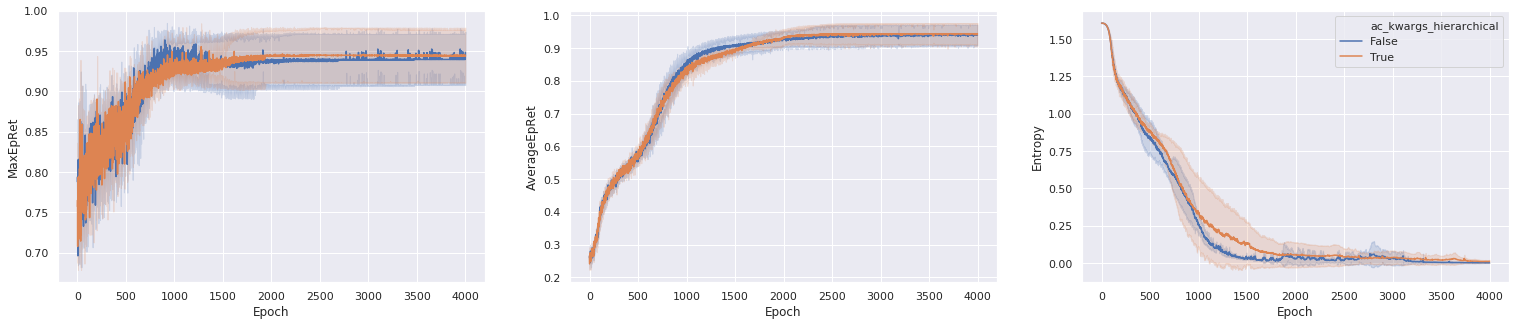

In [20]:
fig, ax = plt.subplots(1,3, figsize=(26, 5))
sns.lineplot(x='Epoch', y='MaxEpRet', data=df, hue='ac_kwargs_hierarchical', ci='sd', legend=None, ax=ax[0])
sns.lineplot(x='Epoch', y='AverageEpRet', data=df, hue='ac_kwargs_hierarchical', ci='sd', legend=None, ax=ax[1])
sns.lineplot(x='Epoch', y='Entropy', data=df, hue='ac_kwargs_hierarchical', ci='sd',  ax=ax[2])

['MgF2 120 nm|Si 45 nm|Ge 35 nm|Cr 200 nm, Merit 0.916']

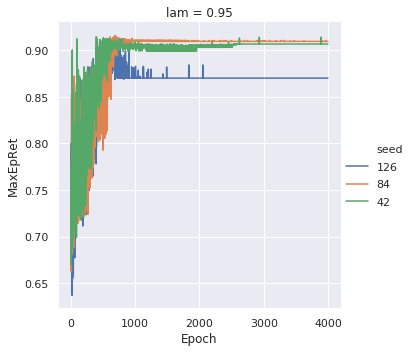

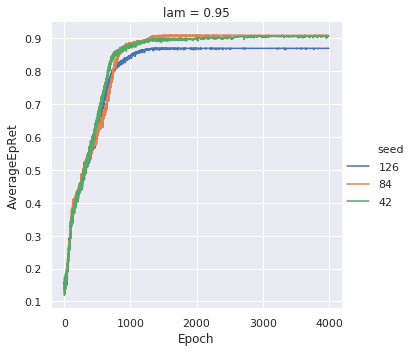

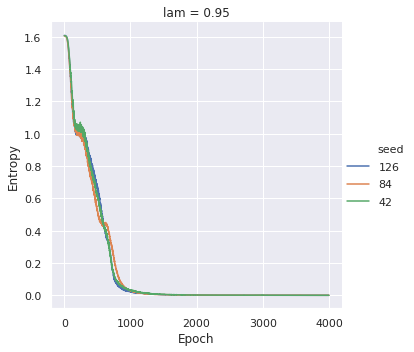

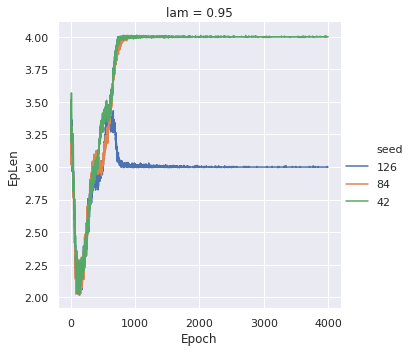

In [21]:
folder = '/home/hzwang/Experiments/0303_hierarchical_len5'
df_ppo = load_exp_res(folder)
# df_ppo = df_ppo[df_ppo['seed'] != 42]
df_ppo['seed'] = ['$%s$' %item for item in df_ppo['seed']]
sns.relplot(x='Epoch', y='MaxEpRet', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')
sns.relplot(x='Epoch', y='AverageEpRet', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')
sns.relplot(x='Epoch', y='Entropy', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')
sns.relplot(x='Epoch', y='EpLen', data=df_ppo, hue='seed', ci='sd', col='lam', kind='line')

df_ppo.iloc[df_ppo['MaxEpRet'].to_numpy().argmax()]['best_design']

In [22]:
best_designs = []
for s in df_ppo['seed'].unique():
    best_designs.append(df_ppo[df_ppo['seed']==s]['best_design'].iloc[0])

[['MgF2 105 nm|TiO2 65 nm|Ge 35 nm|Cr 180 nm, Merit 0.913'],
 ['MgF2 120 nm|Si 45 nm|Ge 35 nm|Cr 200 nm, Merit 0.916'],
 ['MgF2 120 nm|Si 40 nm|Ge 35 nm|Cr 185 nm, Merit 0.914']]

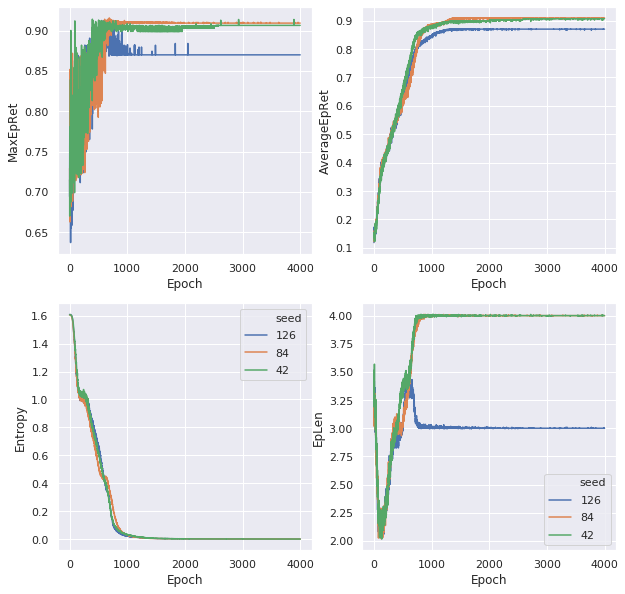

In [12]:
folder = '/home/hzwang/Experiments/0303_hierarchical_len5'
visualize_results(folder)

[['MgF2 85 nm|TiO2 55 nm|Si 55 nm|Ge 30 nm|Cr 135 nm, Merit 0.920'],
 ['MgF2 115 nm|TiO2 45 nm|Si 50 nm|Ge 30 nm|Cr 135 nm, Merit 0.938'],
 ['MgF2 120 nm|TiO2 15 nm|Si 50 nm|Ge 30 nm|Cr 185 nm, Merit 0.922'],
 ['MgF2 140 nm|Si 45 nm|Ge 35 nm|Cr 165 nm, Merit 0.914'],
 ['MgF2 140 nm|Si 75 nm|Cr 15 nm|Si 75 nm|Cr 175 nm, Merit 0.911'],
 ['MgF2 165 nm|TiO2 45 nm|Si 45 nm|Ge 40 nm|Cr 135 nm, Merit 0.917'],
 ['TiO2 60 nm|Si 60 nm|Cr 15 nm|Si 60 nm|Cr 165 nm, Merit 0.912'],
 ['MgF2 135 nm|Si 45 nm|Ge 35 nm|Cr 200 nm, Merit 0.915'],
 ['MgF2 110 nm|TiO2 35 nm|Si 40 nm|Ge 25 nm|Cr 190 nm, Merit 0.940'],
 ['MgF2 160 nm|Si 70 nm|Cr 15 nm|Si 60 nm|Cr 85 nm, Merit 0.918']]

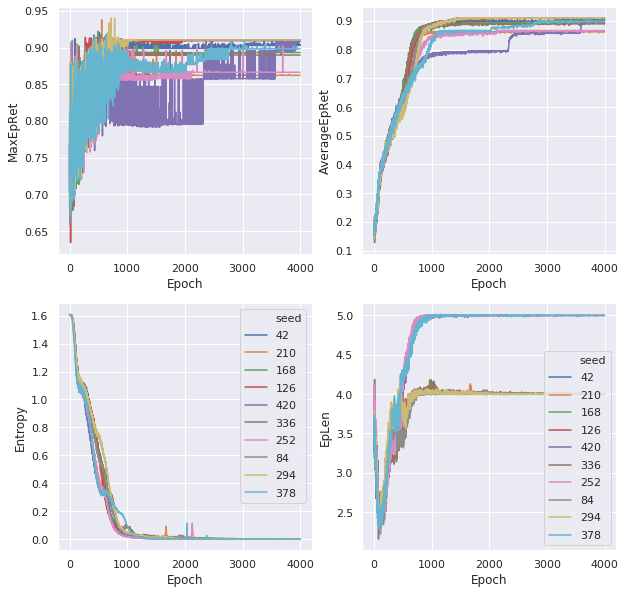

In [7]:
folder = '/home/hzwang/Experiments/0303_hierarchical_len6'
visualize_results(folder)

[['MgF2 125 nm|TiO2 50 nm|Si 40 nm|Ge 25 nm|Cr 25 nm|Si 40 nm|Cr 25 nm|TiO2 40 nm|Cr 155 nm, Merit 0.986'],
 ['MgF2 110 nm|TiO2 45 nm|Si 35 nm|Ge 35 nm|Cr 35 nm|Ge 35 nm|Cr 45 nm|Ge 40 nm|Cr 185 nm, Merit 0.973'],
 ['MgF2 120 nm|TiO2 50 nm|Si 20 nm|Ge 35 nm|Cr 20 nm|Ge 20 nm|Cr 195 nm|Ge 85 nm|Cr 95 nm, Merit 0.970']]

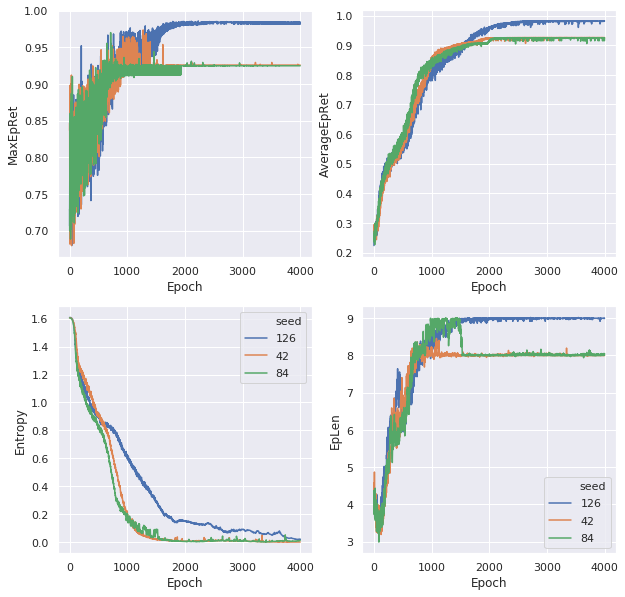

In [13]:
folder = '/home/hzwang/Experiments/0303_hierarchical'
visualize_results(folder)

[['MgF2 110 nm|TiO2 60 nm|Si 60 nm|Cr 15 nm|TiO2 60 nm|Cr 15 nm|MgF2 65 nm|Cr 55 nm|MgF2 60 nm|Cr 60 nm, Merit 0.961'],
 ['MgF2 115 nm|TiO2 65 nm|Si 25 nm|Ge 25 nm|Cr 25 nm|Ge 35 nm|Cr 25 nm|TiO2 25 nm|Cr 120 nm|TiO2 25 nm|Cr 25 nm, Merit 0.975'],
 ['MgF2 105 nm|TiO2 50 nm|Si 15 nm|TiO2 15 nm|Ge 15 nm|Si 15 nm|Cr 15 nm|Ge 15 nm|MgF2 15 nm|Cr 20 nm|MgF2 85 nm|Cr 115 nm, Merit 0.985'],
 ['MgF2 100 nm|TiO2 25 nm|MgF2 15 nm|TiO2 15 nm|Si 15 nm|TiO2 15 nm|Ge 15 nm|Si 15 nm|Cr 15 nm|Ge 15 nm|Si 25 nm|Cr 125 nm|TiO2 60 nm|Cr 100 nm, Merit 0.986'],
 ['MgF2 140 nm|TiO2 35 nm|MgF2 15 nm|Si 15 nm|TiO2 15 nm|Si 15 nm|Ge 15 nm|Si 15 nm|Cr 15 nm|Ge 15 nm|TiO2 35 nm|Cr 35 nm|TiO2 80 nm|Cr 115 nm, Merit 0.988'],
 ['MgF2 135 nm|TiO2 25 nm|MgF2 20 nm|Si 20 nm|TiO2 20 nm|Ge 20 nm|Si 20 nm|Cr 20 nm|Ge 20 nm|Si 20 nm|Cr 25 nm|Si 85 nm|Cr 115 nm, Merit 0.977'],
 ['MgF2 140 nm|TiO2 20 nm|MgF2 20 nm|Si 20 nm|TiO2 20 nm|Ge 20 nm|Si 20 nm|Cr 20 nm|Ge 20 nm|Si 20 nm|Cr 20 nm|Ge 25 nm|Cr 195 nm|Ge 200 nm, Merit 0

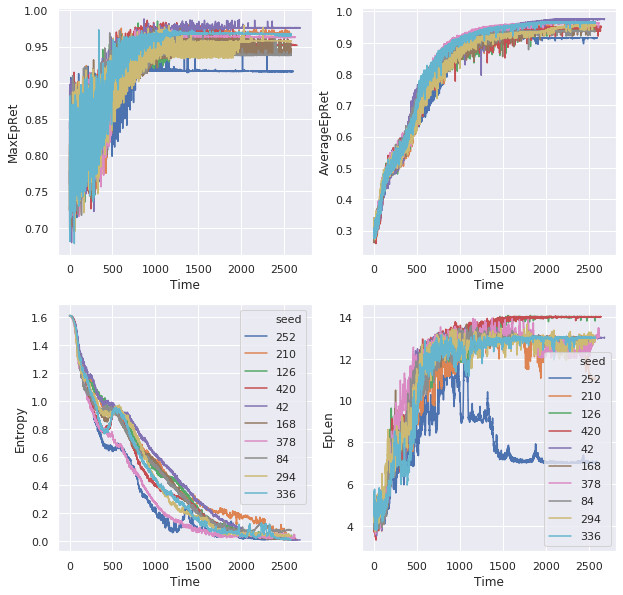

In [14]:
folder = '/home/hzwang/Experiments/0304_more_layers'
visualize_results(folder, x='Time')

In [ ]:
folder = '/home/hzwang/Experiments/0305_piano_less_materials'
design = visualize_results(folder, x='Epoch')

In [ ]:
folder = '/home/hzwang/Experiments/0305_piano_20'
design = visualize_results(folder, x='Epoch')

In [ ]:
# folder = '/home/hzwang/Experiments/0306_piano_three_layers/'
# design = visualize_results(folder, x='Epoch')

In [ ]:
folder = '/home/hzwang/Experiments/0306_piano_si/'
design = visualize_results(folder, x='Epoch')

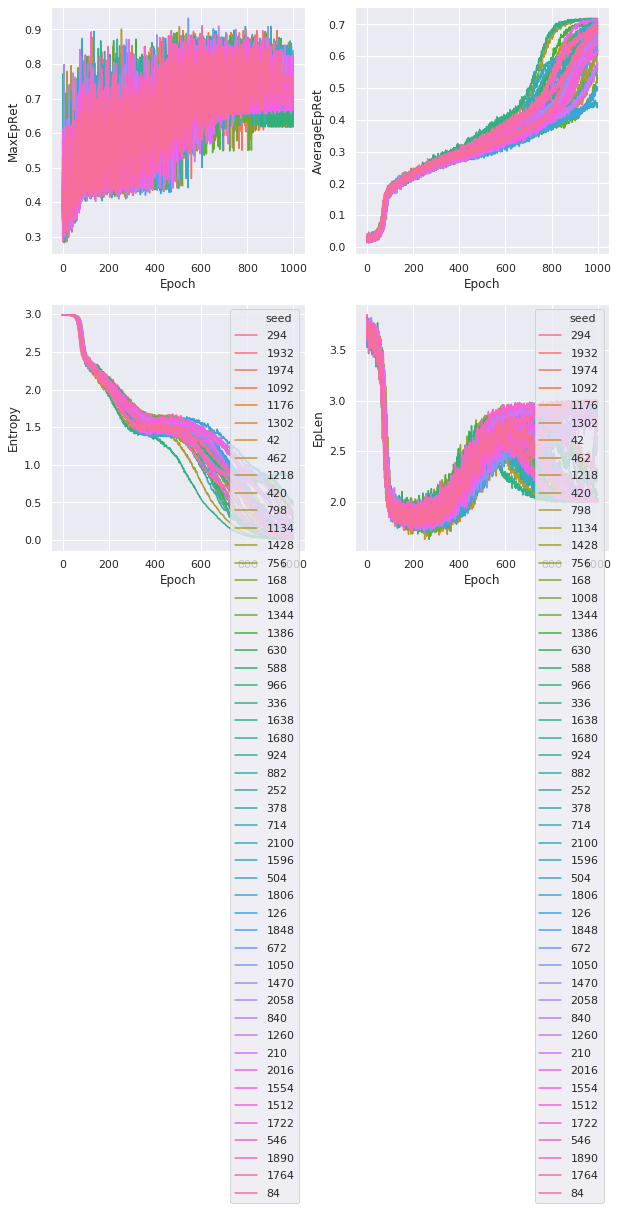

In [243]:
folder = '/home/hzwang/Experiments/0306_piano_10/'
design = visualize_results(folder, x='Epoch')

In [244]:
m0s, x0s, merits = extract_designs(design)
print(design)

[['Al2O3 55 nm|Fe2O3 40 nm|Ti 185 nm, Merit 0.884'], ['MgF2 90 nm|Fe2O3 35 nm|Ge 170 nm, Merit 0.865'], ['MgF2 75 nm|Sputter-Si 50 nm|Ti 105 nm, Merit 0.897'], ['MgF2 100 nm|Sputter-Si 195 nm|Ge 85 nm, Merit 0.873'], ['SiO2 80 nm|Fe2O3 30 nm|Ge 180 nm, Merit 0.891'], ['MgF2 80 nm|Sputter-Si 45 nm|Ti 95 nm, Merit 0.897'], ['MgF2 65 nm|Fe2O3 50 nm|Ti 150 nm, Merit 0.888'], ['SiO2 80 nm|Fe2O3 30 nm|Ge 175 nm, Merit 0.908'], ['MgF2 100 nm|Sputter-Si 195 nm|Ge 85 nm, Merit 0.873'], ['Al2O3 75 nm|Fe2O3 30 nm|Ge 180 nm, Merit 0.854'], ['Al2O3 90 nm|Si 15 nm|Ti 85 nm, Merit 0.901'], ['Al2O3 95 nm|Sputter-Si 200 nm|Ge 180 nm, Merit 0.862'], ['MgF2 75 nm|Sputter-Si 50 nm|Ti 155 nm, Merit 0.897'], ['MgF2 55 nm|Fe2O3 50 nm|Ti 145 nm, Merit 0.878'], ['MgF2 65 nm|Fe2O3 50 nm|Ti 120 nm, Merit 0.888'], ['MgF2 90 nm|Fe2O3 75 nm|Ge 130 nm, Merit 0.873'], ['MgF2 75 nm|Sputter-Si 45 nm|Ti 90 nm, Merit 0.894'], ['MgF2 95 nm|Fe2O3 70 nm|Ge 130 nm, Merit 0.868'], ['Al2O3 55 nm|Fe2O3 40 nm|Ti 175 nm, Merit 0.



0it [00:00, ?it/s]

Ag
Al
Al2O3
Cr
Fe2O3
Ge
HfO2
MgF2
Ni
Si
Si3N4
SiO2
Ti
TiN
TiO2
ZnO
ZnS
ZnSe
PECVD-Si
Sputter-Si




1it [00:04,  4.08s/it]

2it [00:09,  4.39s/it]

3it [00:15,  4.94s/it]

4it [00:17,  4.16s/it]

5it [00:24,  4.79s/it]

6it [00:29,  5.08s/it]

7it [00:31,  3.94s/it]

8it [00:35,  4.12s/it]

9it [00:37,  3.58s/it]

10it [00:43,  4.29s/it]

11it [00:48,  4.25s/it]

12it [00:51,  4.02s/it]

13it [00:54,  3.77s/it]

14it [00:57,  3.58s/it]

15it [00:59,  2.94s/it]

16it [01:02,  3.13s/it]

17it [01:05,  2.98s/it]

18it [01:09,  3.30s/it]

19it [01:12,  3.27s/it]

20it [01:19,  4.44s/it]

21it [01:25,  4.85s/it]

22it [01:30,  4.93s/it]

23it [01:32,  4.07s/it]

24it [01:36,  4.04s/it]

25it [01:40,  4.04s/it]

26it [01:48,  5.26s/it]

27it [01:54,  5.34s/it]

28it [01:58,  4.84s/it]

29it [02:01,  4.30s/it]

30it [02:05,  4.20s/it]

31it [02:13,  5.38s/it]

32it [02:15,  4.51s/it]

33it [02:18,  4.05s/it]

34it [02:23,  4.27s/it]

35it [02:26,  3.77s/it]

36it [02:30,  3.87s/it]

37it [02:34,  3.88s/it]

38it [02:38,  4.11s/it]

39it [02:41,  3.60s/it]

40it [02:43,  3.28s/it]

41it [0

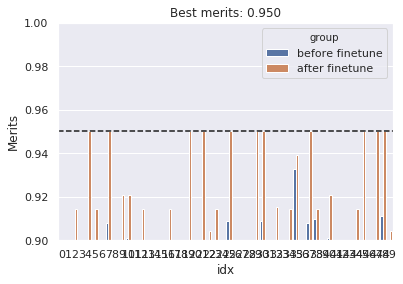

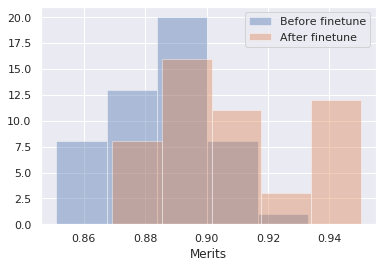

In [246]:
x_opts = []
merits_opt = []
materials = ['Ag', 'Al', 'Al2O3', 'Cr', 'Fe2O3', 'Ge', 'HfO2', 'MgF2', 'Ni', 'Si', 'Si3N4', 'SiO2', 'Ti', 'TiN', 'TiO2', 'ZnO', 'ZnS', 'ZnSe', 'PECVD-Si', 'Sputter-Si']
wavelengths = np.arange(lamda_low, lamda_high+1e-3, 0.005)
target = {'R': np.ones_like(wavelengths) * 0.1, 'A':np.ones_like(wavelengths) * 0.9}
simulator = TMM_sim(materials, wavelengths, substrate='Air')
for m0, x0 in tqdm.tqdm(zip(m0s, x0s)):
    x_opt, res = finetune(simulator, m0, x0, target, display=False)
    merits_opt.append(1 - res.fun)
    
df = pd.DataFrame({'idx':list(range(len(merits))) * 2, 'group':['before finetune'] * len(merits) + ['after finetune'] * len(merits), 'Merits':merits+merits_opt})
    
sns.barplot(x='idx', y='Merits', data=df, hue='group')
plt.ylim(0.9, 1.0)
plt.axhline(np.max(merits_opt), linestyle='--', color='k')
plt.title('Best merits: {:.3f}'.format(np.max(merits_opt)))
plt.show()

sns.distplot(df[df['group']=='before finetune']['Merits'], bins=5, kde=False)
sns.distplot(df[df['group']=='after finetune']['Merits'], bins=5, kde=False)
plt.legend(['Before finetune', 'After finetune'])

In [332]:
np.array(merits_opt)[sort_idx]

array([0.95022246, 0.95022246, 0.95022225, 0.95022148, 0.95022132,
       0.95022045, 0.95022045, 0.95021974, 0.95021691, 0.95021016,
       0.95020573, 0.9394033 , 0.92089156, 0.92073766, 0.92073146,
       0.91548329, 0.91449786, 0.91449771, 0.91449008, 0.91448577,
       0.91445873, 0.91443342, 0.91440963, 0.91440943, 0.90430685,
       0.90417231, 0.89916392, 0.89911137, 0.89764118, 0.89761377,
       0.89759792, 0.89759789, 0.89418445, 0.89415257, 0.89414174,
       0.8941395 , 0.89412469, 0.89409419, 0.89403631, 0.8858738 ,
       0.88587376, 0.88587279, 0.88388311, 0.88388253, 0.87976525,
       0.87696111, 0.87696111, 0.87212006, 0.86991088, 0.86921638])

In [330]:
sort_idx = np.argsort(merits_opt)[::-1]
print(np.array(design)[sort_idx])

[['SiO2 80 nm|Fe2O3 30 nm|Ge 175 nm, Merit 0.908']
 ['SiO2 80 nm|Fe2O3 30 nm|Ge 175 nm, Merit 0.908']
 ['SiO2 75 nm|Fe2O3 35 nm|Ge 165 nm, Merit 0.883']
 ['SiO2 80 nm|Fe2O3 30 nm|Ge 180 nm, Merit 0.891']
 ['SiO2 75 nm|Fe2O3 35 nm|Ge 160 nm, Merit 0.876']
 ['SiO2 85 nm|Fe2O3 35 nm|Ge 180 nm, Merit 0.909']
 ['SiO2 85 nm|Fe2O3 35 nm|Ge 180 nm, Merit 0.909']
 ['SiO2 85 nm|Fe2O3 35 nm|Ge 160 nm, Merit 0.898']
 ['SiO2 85 nm|Fe2O3 35 nm|Ge 185 nm, Merit 0.899']
 ['SiO2 85 nm|Fe2O3 35 nm|Ge 170 nm, Merit 0.911']
 ['SiO2 90 nm|Fe2O3 35 nm|Ge 165 nm, Merit 0.882']
 ['Al2O3 85 nm|Si 15 nm|Ge 160 nm, Merit 0.933']
 ['Al2O3 90 nm|Si 15 nm|Ti 85 nm, Merit 0.901']
 ['Al2O3 70 nm|Fe2O3 30 nm|Ge 170 nm, Merit 0.901']
 ['Al2O3 75 nm|Fe2O3 30 nm|Ge 180 nm, Merit 0.854']
 ['Al2O3 70 nm|Fe2O3 35 nm|Ge 170 nm, Merit 0.877']
 ['MgF2 80 nm|Sputter-Si 45 nm|Ti 95 nm, Merit 0.897']
 ['MgF2 75 nm|Sputter-Si 45 nm|Ti 85 nm, Merit 0.893']
 ['MgF2 75 nm|Sputter-Si 50 nm|Ti 105 nm, Merit 0.897']
 ['MgF2 85 nm|Sputte

[90, 15, 85] ['Al2O3', 'Si', 'Ti'] 0.9502224564424948
Ag
Al
Al2O3
Cr
Fe2O3
Ge
HfO2
MgF2
Ni
Si
Si3N4
SiO2
Ti
TiN
TiO2
ZnO
ZnS
ZnSe
PECVD-Si
Sputter-Si


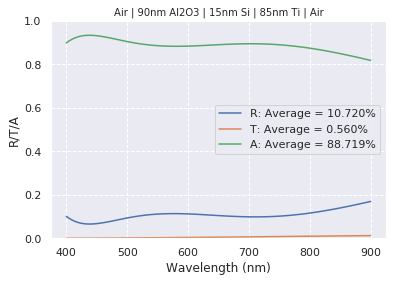

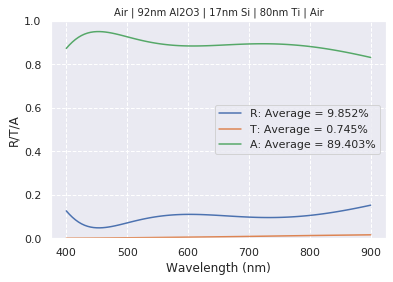

In [351]:
best_idx = np.argmax(merits_opt)
x0, m0 = x0s[best_idx], m0s[best_idx]

x0, m0 = [90, 15, 85], ['Al2O3', 'Si', 'Ti']
# MgF2 80 nm|Sputter-Si 45 nm|Ti 95 nm
# x0, m0 = [80, 45, 95], ['MgF2', 'Sputter-Si', 'Ti']

print(x0, m0, merits_opt[best_idx])

wavelengths = np.arange(lamda_low, lamda_high+1e-3, 0.005)
target = {'R': np.ones_like(wavelengths) * 0.1, 'A':np.ones_like(wavelengths) * 0.9}
simulator = TMM_sim(materials, wavelengths, substrate='Air')

# x_opt, res = finetune(simulator, m0, x0, target, display=True)
x_opt, res = finetune(simulator, m0, x0, target, display=True, bounds=[(15, 200), (15, 200), (15, 80)])

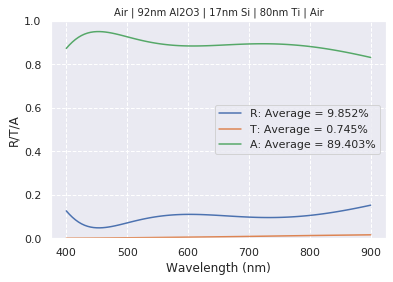

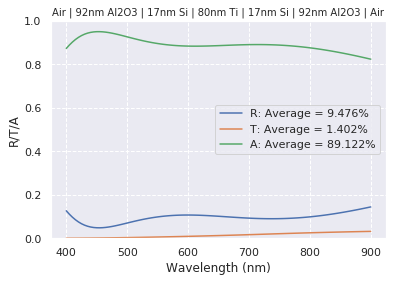

In [352]:
# plot single-side structures
plt.figure()
_ = simulator.spectrum(m0, [np.inf] + x_opt + [np.inf], plot=True, title=True)

# plot symmetric structures
plt.figure()
_ = simulator.spectrum(m0+m0[:-1][::-1], [np.inf] + x_opt+x_opt[:-1][::-1] + [np.inf], plot=True, title=True)

In [353]:
Rs = []
wavelengths = np.arange(lamda_low, lamda_high+1e-3, 0.001)
simulator = TMM_sim(m0, wavelengths, substrate='Air', substrate_thick=100)
for d in tqdm.tqdm_notebook(np.arange(0, 90, 0.5)):
    R, T, A = simulator.spectrum(m0, [np.inf]+x0+[np.inf], theta=d)
    Rs.append(R)
    
Rs = np.array(Rs)

Al2O3
Si
Ti


'hsv'

Text(0.5, 1.0, 'Reflection')

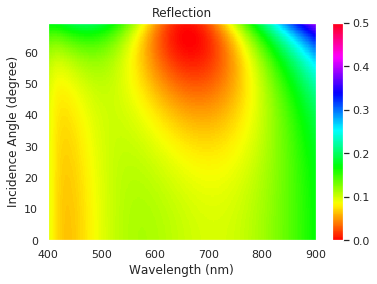

In [354]:
Rs = []
wavelengths = np.arange(lamda_low, lamda_high+1e-3, 0.001)
simulator = TMM_sim(m0, wavelengths, substrate='Air', substrate_thick=100)
for d in tqdm.tqdm_notebook(np.arange(0, 90, 0.5)):
    R, T, A = simulator.spectrum(m0, [np.inf]+x0+[np.inf], theta=d)
    Rs.append(R)
    
Rs = np.array(Rs)

fig, ax = plt.subplots()

x, y  = np.meshgrid(wavelengths*1000, np.arange(0, 70, 0.5))
# c = ax.pcolormesh(x, y, Rs-0.2, cmap='RdBu', vmin=-0.2, vmax=0.2)
c = ax.pcolormesh(x, y, Rs[:len(y)], cmap='hsv', vmin=0, vmax=0.5)
fig.colorbar(c, ax=ax)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Incidence Angle (degree)')
# plt.title(r'Difference from 20% reflection $R-0.2$')
plt.title('Reflection')

# Render the learned device

In [13]:
# RL: [‘MgF2 185 nm|TiO2 60 nm|Si 20 nm|Ge 35 nm|Cr 185 nm, Merit 0.930’]
# Human: [‘MgF2 118 nm|TiO2 56 nm|Si 32 nm|Ge 33 nm|Cr 200 nm, Merit 0.95975’]

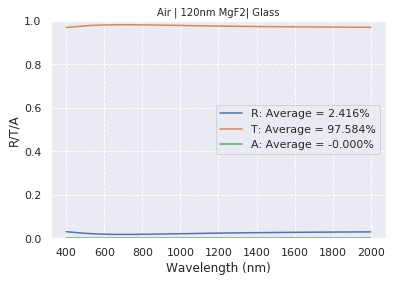

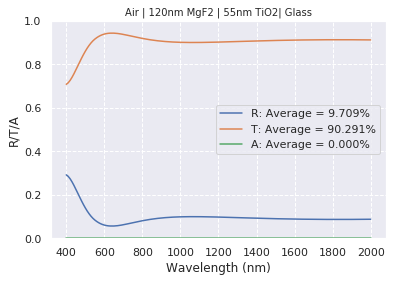

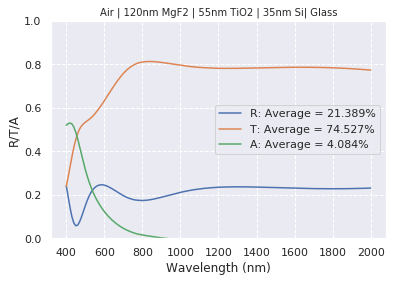

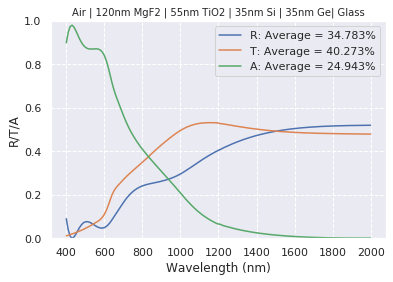

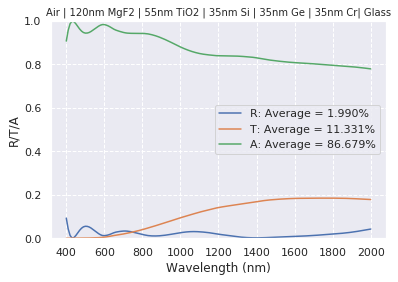

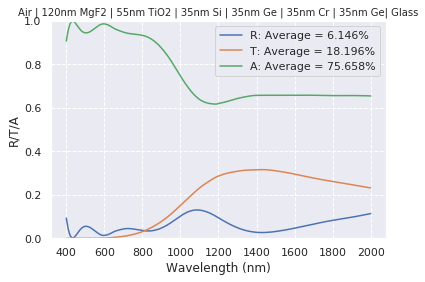

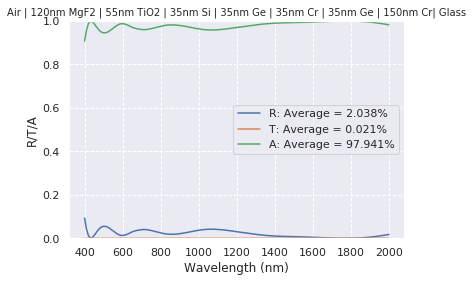

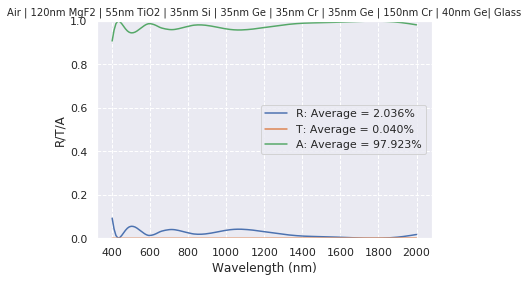

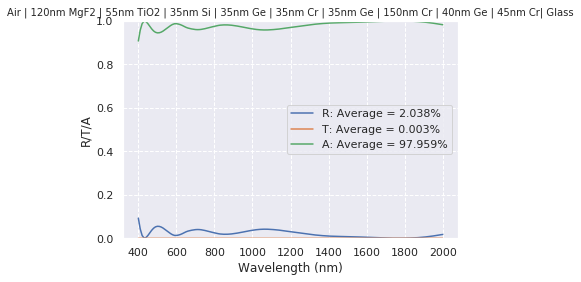

In [9]:



# MgF2 95 nm|TiO2 65 nm|Ge 40 nm|Cr 145 nm|Cr 1...
# materials = ['MgF2', 'TiO2', 'Ge', 'Cr', 'Cr']
# thickness = [np.inf, 95, 65, 40, 145, 180, np.inf]

# materials = ['MgF2', 'TiO2', 'Si', 'Ge', 'Cr']
# thickness = [np.inf, 118, 56, 32, 33, 200, np.inf]

materials = ['TiO2', 'Si', 'Cr', 'TiO2', 'Cr']
thickness = [np.inf, 60, 55, 15, 85, 120, np.inf]

materials = ['MgF2', 'TiO2', 'Si', 'Ge', 'Cr', 'TiO2', 'Si', 'Ge']
thickness = [np.inf, 115, 45, 40, 35, 170, 140, 135, 50, np.inf]

# materials = ['TiO2', 'MgF2', "TiO2", 'Si', 'Ge', 'Cr', 'Ge', 'Cr', 'Ge']
# thickness = [np.inf, 25, 35, 65, 35, 25, 25, 25, 195, 195, np.inf]

# materials = ['TiO2', 'MgF2', "TiO2", 'Si', 'Ge', 'Cr', 'Ge', 'Cr']
# thickness = [np.inf, 25, 35, 65, 35, 25, 25, 25, 195, np.inf]



materials = ['MgF2', 'TiO2', "Si", 'Ge', 'Cr', 'Ge', 'Cr', 'Ge', 'Cr']
thickness = [np.inf, 120, 55, 35, 35, 35, 35, 150, 40, 45, np.inf]

# ['MgF2 135 nm|TiO2 45 nm|Si 35 nm|Ge 35 nm|Cr 25 nm|Ge 35 nm|Cr 35 nm|Ge 40 nm|Cr 125 nm, Merit 0.979']

# ['MgF2 120 nm|TiO2 55 nm|Si 35 nm|Ge 35 nm|Cr 35 nm|Ge 35 nm|Cr 150 nm|Ge 40 nm|Cr 45 nm, Merit 0.978']

# ['MgF2 115 nm|TiO2 45 nm|Si 35 nm|Ge 35 nm|Cr 35 nm|Ge 40 nm|Cr 170 nm|Ge 35 nm, Merit 0.975']

# ['MgF2 115 nm|TiO2 70 nm|Si 35 nm|Ge 35 nm|Cr 35 nm|Ge 40 nm|Cr 45 nm, Merit 0.955']
# ['TiO2 25 nm|MgF2 35 nm|TiO2 65 nm|Si 35 nm|Ge 25 nm|Cr 25 nm|Ge 25 nm|Cr 195 nm|Ge 195 nm, Merit 0.967']

# ['TiO2 30 nm|MgF2 30 nm|TiO2 60 nm|Si 30 nm|Ge 30 nm|Cr 30 nm|Ge 20 nm|Cr 135 nm, Merit 0.956']

# ['MgF2 115 nm|TiO2 45 nm|Si 40 nm|Ge 35 nm|Cr 170 nm|TiO2 140 nm|Si 135 nm|Ge 50 nm, Merit 0.949']

# ['TiO2 60 nm|Si 55 nm|Cr 15 nm|TiO2 85 nm|Cr 120 nm, Merit 0.921']

# materials = ['MgF2', 'TiO2', 'Si', 'Ge', 'Cr']
# thickness = [np.inf, 120, 60, 35, 35, 200, np.inf]

# materials = ['TiO2', 'Si', 'Ge', 'Cr', 'Cr']
# thickness = [np.inf, 60, 35, 35, 200, 200, np.inf]

wavelength = np.arange(0.4, 2.005, 0.01)
for i in range(1,len(materials)+1):
    env = TMM_sim(materials, wavelength)
    plt.figure()
    R, T, A = env.spectrum(materials[:i], thickness[:i+1]+[np.inf], plot=True, title=True, theta=1)

In [94]:
lamda_low, lamda_high = 0.4, 2.0
wavelengths = np.arange(lamda_low, lamda_high+1e-3, 0.01)
materials = ['Cr', 'Ge', 'Si', 'TiO2', 'MgF2']
simulator = TMM_sim(materials, wavelengths)

def finetune(simulator, m0, x0, display=False):
    '''
    Finetune the structure using quasi-Newton's method.
    
    Args:
        m0: materials list given by the upstream RL
        x0: thicknesses given by the upstream RL
        display: if true, then plot the spectrum before and after the finetuning.
        
    Returns:
        x_opt: finetuned thickness list
    '''
    
    def objective_func(x):
        R, T, A = simulator.spectrum(m0, [np.inf]+list(x)+[np.inf])
        return 1 - A.mean()
    
    res = minimize(objective_func, x0, bounds=[(15, 200)] * len(x0), options={'disp':True})
    x_opt = [int(item) for item in res.x]
    
    if display:
        plt.figure()
        simulator.spectrum(m0, [np.inf]+x0+[np.inf], title=True, plot=True)
        plt.figure()
        simulator.spectrum(m0, [np.inf]+x_opt+[np.inf], title=True, plot=True)
    
    return x_opt, res

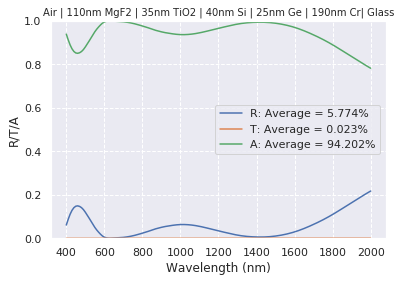

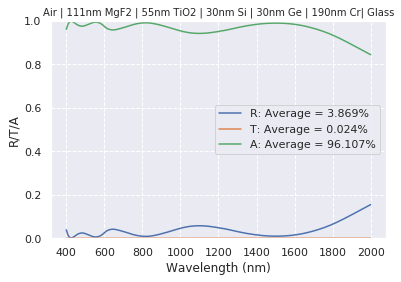

In [77]:
# five layer structure
m0 = ['MgF2', 'TiO2', 'Si', 'Ge', 'Cr']
x0 = [110, 35, 40, 25, 190]
x_opt, _ = finetune(simulator, m0, x0, display=True)

In [5]:
# 10-layer structure
m0 = ['MgF2', 'TiO2', 'Si', 'Ge', 'Cr', 'Si', 'Cr', 'TiO2', 'Cr']
x0 = [125, 50, 40, 25, 25, 40, 25, 40, 155]
x_opt, _ = finetune(simulator, m0, x0, display=True)

NameError: name 'finetune' is not defined

In [155]:
designs = [['MgF2 140 nm|TiO2 35 nm|MgF2 15 nm|Si 15 nm|TiO2 15 nm|Si 15 nm|Ge 15 nm|Si 15 nm|Cr 15 nm|Ge 15 nm|TiO2 35 nm|Cr 35 nm|TiO2 80 nm|Cr 115 nm, Merit 0.988']]
m0, x0, merit = extract_designs(designs)

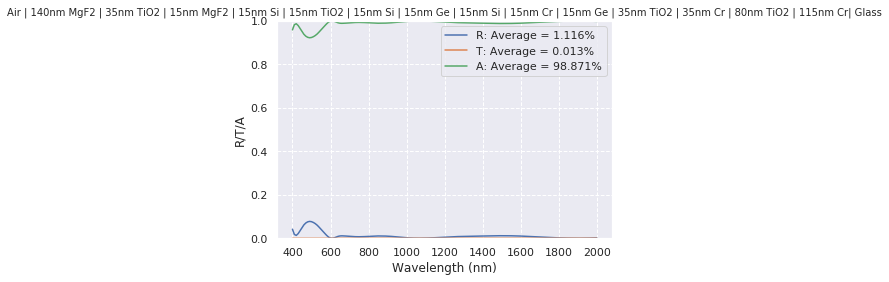

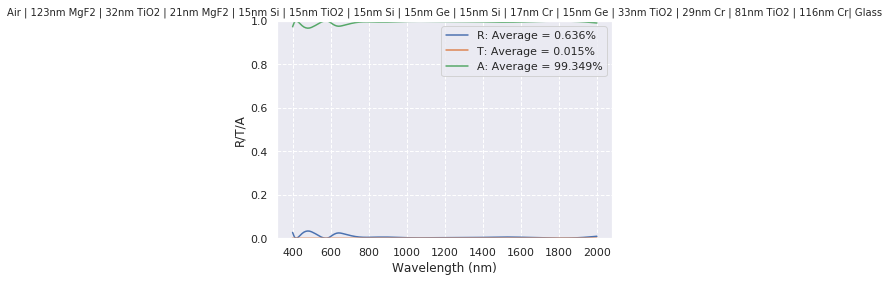

In [158]:
x_opt, _ = finetune(simulator, m0, x0, display=True)

# compare finetuning effect

In [152]:
from tqdm.notebook import tqdm

In [153]:
def extract_designs(best_designs):
    m0s = []
    x0s = []
    merits = []
    for i in range(len(best_designs)):
        design = best_designs[i][0].split(',')[0].split('|')
        m0 = [item.split(' ')[0] for item in design]
        x0 = [item.split(' ')[1] for item in design]
        merit = best_designs[i][0].split(',')[1].split(' ')[2]

        m0s.append(m0)
        x0s.append(x0)
        merits.append(float(merit))
    return m0, x0, merits

In [100]:
merits = [float(item) for item in merits]
merits_opt = [1-item for item in merits_opt]

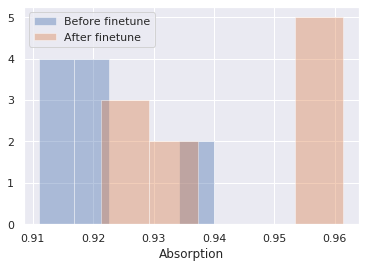

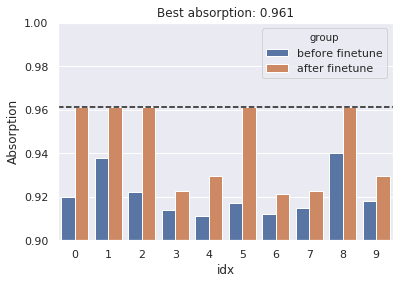

In [ ]:
x_opts = []
merits_opt = []
for m0, x0 in tqdm(zip(m0s, x0s)):
    x_opt, res = finetune(simulator, m0, x0, display=False)
    merits_opt.append(1 - res.fun)
    
df = pd.DataFrame({'idx':list(range(len(merits))) * 2, 'group':['before finetune'] * len(merits) + ['after finetune'] * len(merits), 'Absorption':merits+merits_opt})
    
sns.barplot(x='idx', y='Absorption', data=df, hue='group')
plt.ylim(0.9, 1.0)
plt.axhline(np.max(merits_opt), linestyle='--', color='k')
plt.title('Best absorption: {:.3f}'.format(np.max(merits_opt)))
plt.show()

sns.distplot(df[df['group']=='before finetune']['Absorption'], bins=5, kde=False)
sns.distplot(df[df['group']=='after finetune']['Absorption'], bins=5, kde=False)
plt.legend(['Before finetune', 'After finetune'])

In [172]:
wavelengths = np.arange(0.4, 1.001, 0.01)
materials = ['SiO2', 'TiO2', 'MgF2']
simulator = TMM_sim(materials, wavelengths)

In [173]:
700 / 4  * 0.049

8.575000000000001

In [245]:
m0 = ['MgF2', 'TiO2','SiO2', 'TiO2', 'SiO2', 'TiO2', 'SiO2', 'TiO2']
n_dict = {'MgF2':1.38, 'SiO2':1.46, 'TiO2':2.35}
d0 = [0.2906, 0.0962, 0.0633, 0.5341, 0.0453, 0.1179, 0.1150, 0.0490]
x0 = [700/4 * d for d, m in zip(d0, m0)]

In [246]:
x0

[50.855000000000004,
 16.834999999999997,
 11.077499999999999,
 93.4675,
 7.9275,
 20.6325,
 20.125,
 8.575000000000001]

In [243]:
from tmm import coh_tmm

def cal_spectrum(materials, thickness):
    degree = pi/180
    theta = 0
    
    R, T, A = [], [], []
    for i, lambda_vac in enumerate(wavelengths * 1e3):
        n_list = [1] + [n_dict[mat] for mat in materials] + [1.45]
        # print(n_list)
        # n_list = [1] + [self.nk_dict[mat][i] for mat in materials] + [self.nk_dict['Cr'][i]]
        R.append(coh_tmm('s', n_list, thickness,
                         theta * degree, lambda_vac)['R'])
        T.append(coh_tmm('s', n_list, thickness,
                         theta * degree, lambda_vac)['T'])
        
    return R, T, A

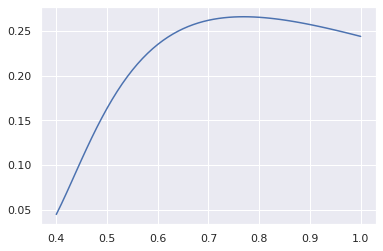

In [244]:
R, T, A = cal_spectrum(m0, [np.inf]+x0+[np.inf])
plt.plot(wavelengths, R)